# Import

In [1]:
from qDrift.hamsimqDrift import AlgorithmHamSimqDrift
from pytket.circuit import Circuit
from openfermion.utils.operator_utils import count_qubits

from utils.func import *
from utils.term_grouping import *
from utils.min_clique import *
from utils.hamlib import *
from utils.evol_real import *
from utils.plot import *
from utils.driver import *
from utils.JW import *

from Pauli_Gadgets.paulis import *

import numpy as np
import matplotlib.pyplot as plt

def gen_sys_param(n=10, sample_steps=100000, N=1):
    global t_max
    global initial_state_circ
    global n_qdrift_steps
    global sample_space
    global seg
    global t_list

    t_list = [0.5,1,2,5]
    t_max=t_list[-1]
    seg = N
    initial_state_circ = Circuit(n)
    for i in range(n):
        initial_state_circ.H(i)
    n_qdrift_steps = sample_steps
    sample_space = np.arange(0,sample_steps+1,1)

# Hydrogen chain

In [2]:
driver = PySCFDriver_custom()
bond_length = 1.0
n_sites = 5
driver.load_molecule(
    atom=[('H', (0, 0, i * bond_length)) for i in range(n_sites)], # Create a molecular data object for the hydrogen chain
    basis="sto-3g",          # Basis set for quantum chemistry calculation
    multiplicity=1,          # Spin multiplicity for molecule, since the total spin of H2O is S=0，its spin multiplicity is 2S+1=1
    charge=0,                 # Total charge of molecule, since H2O is charge neutral, its charge=0
    unit="Angstrom"
)
driver.run_scf()             # Perform Hartree Fock calculation

# np.set_printoptions(precision=4, linewidth=150)

hpq = driver.get_onebody_tensor("int1e_kin") + driver.get_onebody_tensor("int1e_nuc")
vpqrs = driver.get_twobody_tensor()
# assert np.shape(hpq)==(7, 7)             # H2O has 7 orbitals when using STO-3G basis.
# assert np.shape(vpqrs)==(7, 7, 7, 7)

# print(hpq)
operator = get_molecular_hamiltonian(hpq,vpqrs,driver)
n_qubits = count_qubits(operator)
number, coulomb, hopping, no_excitation, double_excitation = JW_transformation(operator)
numbers, coulombs, hoppings, no_excitations, double_excitations = JW_transformation(operator,True)

number_op, number_co = convert_op_to_input(number,n_qubits)
hopping_op, hopping_co = convert_op_to_input(hopping,n_qubits)
coulomb_op, coulomb_co = convert_op_to_input(coulomb,n_qubits)
no_excitation_op, no_excitation_co = convert_op_to_input(no_excitation,n_qubits)
double_excitation_op, double_excitation_co = convert_op_to_input(double_excitation,n_qubits)

numbers_op, numbers_co = convert_op_to_input(numbers,n_qubits,True)
hoppings_op, hoppings_co = convert_twobody_op_to_input(hoppings,n_qubits,True)
coulombs_op, coulombs_co = convert_op_to_input(list(coulombs),n_qubits,True)
no_excitations_op, no_excitations_co = convert_twobody_op_to_input(list(no_excitations),n_qubits,True)
double_excitations_op, double_excitations_co = convert_twobody_op_to_input(list(double_excitations),n_qubits,True)

# max_part_group = [[number_op[0], number_op[-2],hopping_op[0], hopping_op[1]],number_op[2:4],[number_op[1], number_op[-1], hopping_op[-2],hopping_op[-1]]]+coulombs_op+no_excitations_op+double_excitations_op
# max_coeff = [[(number_co[0]+number_co[-2]+abs(hopping_co[0])*2)/4],[number_co[2]],[(number_co[0]+number_co[-2]+abs(hopping_co[0])*2)/4]]+coulombs_co+no_excitations_co+double_excitations_co
# max_part_group, max_coeff = site_excitation_group(numbers_op,hoppings_op,numbers_co,hoppings_co)

H_matrix = get_Hmatrix(number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,n_qubits,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co)

converged SCF energy = -2.57343663401106


In [ ]:
gen_sys_param(n=n_qubits,sample_steps=100)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg)
U2p,secdepth = drift_time_evolution.trotter(order=2, protected=True,cheat=True)

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=200)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg)
Ut,ldepth = drift_time_evolution.trotter(cheat=True)

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=100)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg)
U2,secdepth = drift_time_evolution.trotter(order=2,cheat=True)

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=200)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg)
Urp,rpdepth = drift_time_evolution.trotter(rand=True, cheat=True)

In [ ]:
def search_depth_with_no_exp(idx,depth):
    for i in range(1,len(depth)):
        # print(depth[i])
        if idx > depth[i]:
            continue
        elif idx == depth[i]:
            return depth[i]
        elif idx < depth[i]:
            if depth[i]-idx > idx-depth[i-1]:
                return depth[i]
            else:
                return depth[i-1]

In [ ]:
def perm_ops(t,depth,sm):
    t_step = t[-1]/depth[0][-1]
    ind = [[],[],[]]
    V = [[],[],[]]
    coeff = [[],[],[]]
    depth_new = [[depth[i][0]] for i in range(len(depth))]
    for i in range(len(depth)):
        for j in range(len(t)):
            idx = int(t[j] / t_step)
            depth_new[i].append(search_depth_with_no_exp(idx,depth[i]))
    for i in range(len(depth_new)):
        for j in range(len(depth_new[i])):
            ind[i].append(depth[i].index(depth_new[i][j]))
    for i in range(len(ind)):
        for j in range(len(ind[i])-1):
            V[i].append(np.random.permutation(sm[0][i][ind[i][j]:ind[i][j+1]]))
            coeff[i].append(np.random.permutation(sm[1][i][ind[i][j]:ind[i][j+1]]))
    return [[item for row in V[i] for item in row] for i in range(3)],[[item for row in coeff[i] for item in row] for i in range(3)]

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,numbers_op+hoppings_op+coulombs_op+no_excitations_op+double_excitations_op,numbers_co+hoppings_co+coulombs_co+no_excitations_co+double_excitations_co,t_max,n_qdrift_steps,seg,M=3)
Um,sm,mdepth = drift_time_evolution.Drift_exp(depth=secdepth[-1], cheat=True)
Um= [[Um[j][0][i] for i in range(len(Um[j][0]))] for j in range(len(Um))]
mdepth = [[mdepth[j][0][i] for i in range(len(mdepth[j][0]))] for j in range(len(mdepth))]

In [ ]:
Vmp, coeffmp = perm_ops(t_list,mdepth,sm)

/var/folders/yl/s3t7xtw12ln0swvb5syyk84w0000gn/T/ipykernel_4137/3638908987.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  V[i].append(np.random.permutation(sm[0][i][ind[i][j]:ind[i][j+1]]))
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,numbers_op+hoppings_op+coulombs_op+no_excitations_op+double_excitations_op,numbers_co+hoppings_co+coulombs_co+no_excitations_co+double_excitations_co,t_max,n_qdrift_steps,seg,M=3)
Ump,smp,mdepthp = drift_time_evolution.Drift_exp(sampled=[Vmp,coeffmp,sm[-1]],depth=secdepth[-1], cheat=True)
Ump= [[Ump[j][0][i] for i in range(len(Ump[j][0]))] for j in range(len(Ump))]
mdepthp = [[mdepthp[j][0][i] for i in range(len(mdepthp[j][0]))] for j in range(len(mdepthp))]

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
drift_time_evolution_parity = AlgorithmHamSimqDrift(initial_state_circ,[[h] for h in number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op],[[c] for c in number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co],t_max,n_qdrift_steps,seg,M=3)
Uq,sq,qdepth = drift_time_evolution_parity.Drift_exp(depth=secdepth[-1], cheat=True)
Uq= [[Uq[j][0][i] for i in range(len(Uq[j][0]))] for j in range(len(Uq))]
qdepth = [[qdepth[j][0][i] for i in range(len(qdepth[j][0]))] for j in range(len(qdepth))]

In [ ]:
Vqp, coeffqp = perm_ops(t_list,qdepth,sq)

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
drift_time_evolution_parity = AlgorithmHamSimqDrift(initial_state_circ,[[h] for h in number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op],[[c] for c in number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co],t_max,n_qdrift_steps,seg,M=3)
Uqp,sqp,qdepthp = drift_time_evolution_parity.Drift_exp(sampled=[Vqp,coeffqp,sq[-1]],depth=secdepth[-1], cheat=True)
Uqp= [[Uqp[j][0][i] for i in range(len(Uqp[j][0]))] for j in range(len(Uqp))]
qdepthp = [[qdepthp[j][0][i] for i in range(len(qdepthp[j][0]))] for j in range(len(qdepthp))]

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=ldepth[-1])
Uexc = U_exc(drift_time_evolution.circuit.get_unitary(),n_qdrift_steps,t_max, H_matrix)

In [ ]:
u2p = extract_U_at_t(t_list,U2p,secdepth)
ut = extract_U_at_t(t_list,Ut,ldepth)
u2 = extract_U_at_t(t_list,U2,secdepth)
urp = extract_U_at_t(t_list,Urp,rpdepth)
# um_ave = extract_U_at_t(t_list,ave_m,ave_mdepth)
# uq_ave = extract_U_at_t(t_list,ave_q,ave_qdepth)
uexc = extract_U_at_t(t_list,Uexc,np.arange(secdepth[-1]))
m_mean,m_std = Monte_Carlo_ave(t_list,Um,mdepth,uexc,M=3)
# g_mean,g_std = Monte_Carlo_ave(t_list,Ug,gdepth,uexc,M=3)
q_mean,q_std = Monte_Carlo_ave(t_list,Uq,qdepth,uexc,M=3)

In [ ]:
def extract_depth_at_t(t,depth):
    t_step = t[-1]/depth[0][-1]
    depth_new = [[depth[i][0]] for i in range(len(depth))]
    for i in range(len(depth)):
        for j in range(len(t)):
            idx = int(t[j] / t_step)
            depth_new[i].append(depth[i][search_U_with_no_exp(idx,depth[i])])
    mean, std = np.mean(depth_new,axis=0), np.std(depth_new,axis=0)
    xerror = [(s/(m+0.0001))*t_step for s,m in zip(std,mean)]
    return xerror

In [ ]:
def cal_std_drift(U, Ur, t, depth, secdepth, ave=False):
    u_noise = []
    t_step = t[-1]/depth[0][-1]
    depth_new = [[depth[i][0]] for i in range(len(depth))]
    for i in range(len(depth)):
        for j in range(len(t)):
            idx = int(t[j] / t_step)
            depth_new[i].append(depth[i][search_U_with_no_exp(idx,depth[i])])
    if not ave:
        for i in range(len(U)):
            u_t = extract_U_at_t(t_list,U[i],secdepth)
            Urt = [Ur[depth_new[i][j]] for j in range(len(depth_new[i]))]
            u_noise.append([np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u_t,Urt)])
        # print(u_noise)
        u_noise_mean, u_noise_std = np.mean(u_noise,axis=0),np.std(u_noise,axis=0) 
        return u_noise_mean, u_noise_std 
    else:
        u_t = []
        for i in range(len(U)):
            u_t.append(extract_U_at_t(t_list,U[i],secdepth))
        # print(u_t[0][0])
        Urt = extract_U_at_t(t_list,Uexc,np.arange(secdepth[-1]))
        # print(np.abs(linalg.eig(np.add(np.add(Um[0][0],Um[1][0]),Um[2][0])/3-Urt[0])[0]).max())
        u = [np.add(np.add(np.array(u_t[0][i]),np.array(u_t[1][i])),np.array(u_t[2][i]))/3 for i in range(len(u_t[0]))]
        # print(u[0])
        error = [np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u,Urt)]
        # print(error)
        return error

In [ ]:
um_spec_ave = cal_std_drift(Um, Uexc, t_list, mdepth, secdepth,True)
uq_spec_ave = cal_std_drift(Uq, Uexc, t_list, qdepth, secdepth, True)
ump_spec_ave = cal_std_drift(Ump, Uexc, t_list, mdepthp, secdepth,True)
uqp_spec_ave = cal_std_drift(Uqp, Uexc, t_list, qdepthp, secdepth, True)

In [ ]:
um_spec_mean, um_spec_std = cal_std_drift(Um, Uexc, t_list, mdepth, secdepth)
uq_spec_mean, uq_spec_std = cal_std_drift(Uq, Uexc, t_list, qdepth, secdepth)
ump_spec_mean, ump_spec_std = cal_std_drift(Ump, Uexc, t_list, mdepthp, secdepth)
uqp_spec_mean, uqp_spec_std = cal_std_drift(Uqp, Uexc, t_list, qdepthp, secdepth)

In [ ]:
um = [extract_U_at_t(t_list,Um[i],secdepth) for i in range(len(Um))]
um_spec = [[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(um[i],uexc)] for i in range(len(um))]
uq = [extract_U_at_t(t_list,Uq[i],secdepth) for i in range(len(Uq))]
uq_spec = [[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(uq[i],uexc)] for i in range(len(uq))]

ump = [extract_U_at_t(t_list,Ump[i],secdepth) for i in range(len(Ump))]
ump_spec = [[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(ump[i],uexc)] for i in range(len(ump))]
uqp = [extract_U_at_t(t_list,Uqp[i],secdepth) for i in range(len(Uqp))]
uqp_spec = [[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(uqp[i],uexc)] for i in range(len(uqp))]

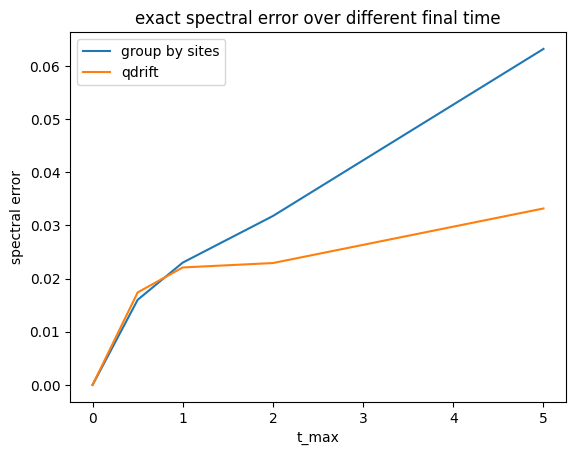

In [ ]:
plt.errorbar([0]+t_list,um_spec_ave, label='group by sites')
plt.errorbar([0]+t_list,uq_spec_ave, label='qdrift')
plt.title('exact spectral error over different final time')
plt.xlabel('t_max')
plt.ylabel('spectral error') 
plt.legend()

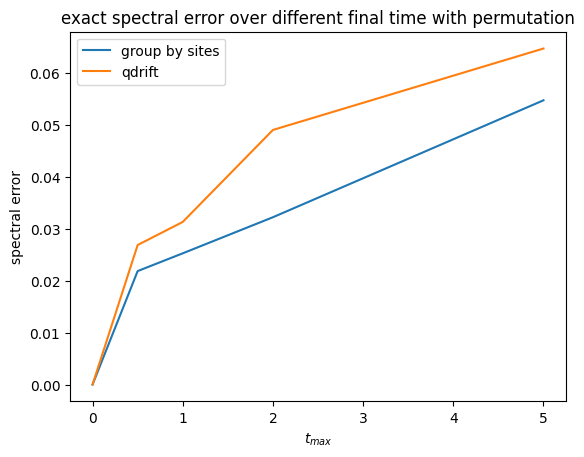

In [ ]:
plt.errorbar([0]+t_list,ump_spec_ave, label='group by sites')
plt.errorbar([0]+t_list,uqp_spec_ave, label='qdrift')
plt.title('exact spectral error over different final time with permutation')
plt.xlabel(r'$t_{max}$')
plt.ylabel('spectral error') 
plt.legend()

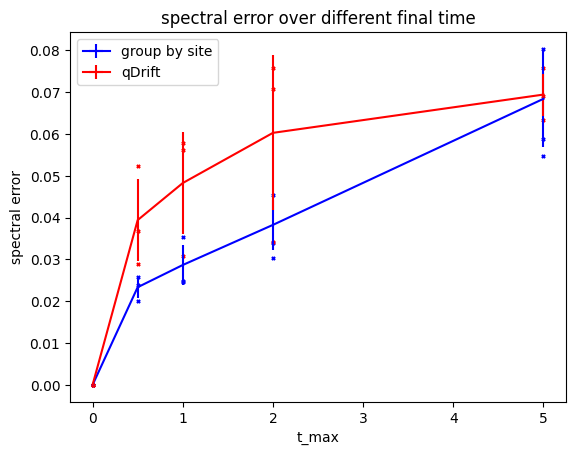

In [ ]:
plt.errorbar([0]+t_list,um_spec_mean ,xerr=extract_depth_at_t(t_list,mdepth),yerr=um_spec_std, label='group by site',color='b')
for i in range(len(um_spec)):
    plt.scatter([0]+t_list,um_spec[i],marker='x',s=5,color='b')
plt.errorbar([0]+t_list,uq_spec_mean ,xerr=extract_depth_at_t(t_list,qdepth),yerr=uq_spec_std, label='qDrift',color='r')
for i in range(len(uq_spec)):
    plt.scatter([0]+t_list,uq_spec[i],marker='x',s=5,color='r')
plt.title('spectral error over different final time')
plt.xlabel('t_max')
plt.ylabel('spectral error') 
plt.legend()

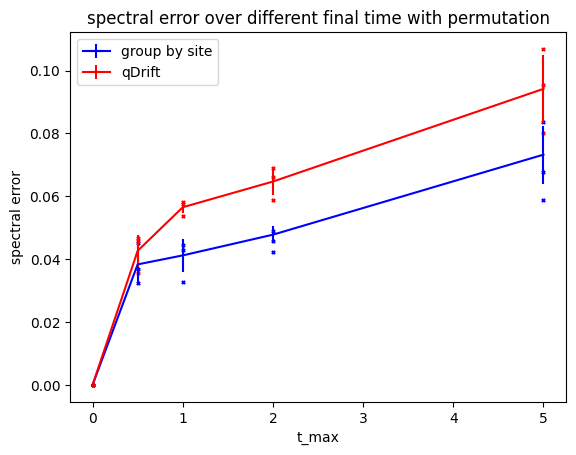

In [ ]:
plt.errorbar([0]+t_list,ump_spec_mean ,xerr=extract_depth_at_t(t_list,mdepthp),yerr=ump_spec_std, label='group by site',color='b')
for i in range(len(ump_spec)):
    plt.scatter([0]+t_list,ump_spec[i],marker='x',s=5,color='b')
plt.errorbar([0]+t_list,uqp_spec_mean ,xerr=extract_depth_at_t(t_list,qdepthp),yerr=uqp_spec_std, label='qDrift',color='r')
for i in range(len(uqp_spec)):
    plt.scatter([0]+t_list,uqp_spec[i],marker='x',s=5,color='r')
plt.title('spectral error over different final time with permutation')
plt.xlabel('t_max')
plt.ylabel('spectral error') 
plt.legend()

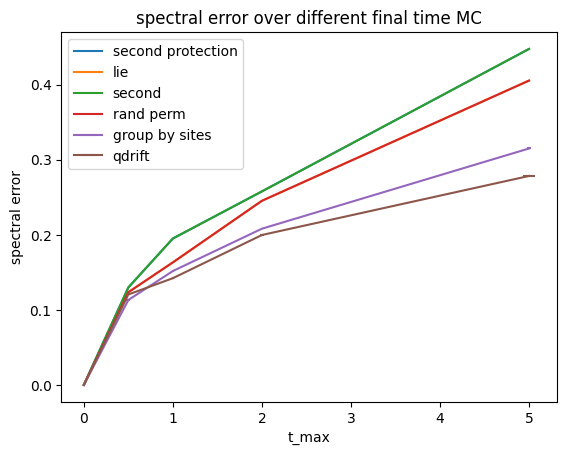

In [ ]:
plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u2p,uexc)],label='second protection')
plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(ut,uexc)],label='lie')
plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u2,uexc)],label='second')
plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(urp,uexc)],label='rand perm')
plt.errorbar([0]+t_list,m_mean ,xerr=m_std, label='group by sites')
# plt.errorbar([0]+t_list,g_mean ,xerr=g_std, label='group by particle_no')
plt.errorbar([0]+t_list,q_mean ,xerr=q_std, label='qdrift')
plt.title('spectral error over different final time MC')
plt.xlabel('t_max')
plt.ylabel('spectral error') 
plt.legend()